In [1]:
# # For Google Colab
# # Mount GDrive
# from google.colab import drive

# drive.mount("/content/drive")

In [2]:
# # For Google Colab
# # Put Colab in the context of this challenge
# import os

# # os.chdir allows you to change directories, like cd in the Terminal
# os.chdir("/content/drive/MyDrive/Colab Notebooks/CXRay/notebooks")

# Data Pre-Processing

In [3]:
import os
import pathlib

import pandas as pd

In [4]:
cwd = os.getcwd()
data_path = pathlib.Path(cwd, "..", "clean_data", "cleaned_data.csv")

data = pd.read_csv(data_path)
data.head()

,img_idx,labels,age,gender,view_pos,label_cardiomegaly,label_effusion,label_no_finding,label_pneumothorax,label_pleural_thickening,label_pneumonia,label_consolidation,label_other
0,00000001_000.png,Cardiomegaly,58,M,PA,True,False,False,False,False,False,False,False
1,00000001_001.png,Cardiomegaly|Emphysema,58,M,PA,True,False,False,False,False,False,False,True
2,00000001_002.png,Cardiomegaly|Effusion,58,M,PA,True,True,False,False,False,False,False,False
3,00000002_000.png,No Finding,81,M,PA,False,False,True,False,False,False,False,False
4,00000003_000.png,Hernia,81,F,PA,False,False,False,False,False,False,False,True


In [5]:
# data = data.drop(columns="label_other")
data = data.drop(columns="label_no_finding")
data.shape

(112104, 12)

In [6]:
# # For Google Colab
# def is_uploaded(filename: str) -> bool:
#     filepath = str(pathlib.Path(cwd, "..", "raw_data", "images_224_224", filename))
#     if os.path.exists(filepath):
#         return os.stat(filepath).st_size != 0
#     return False

# data["image_is_uploaded"] = data.img_idx.apply(lambda x: is_uploaded(x))
# data = data[data.image_is_uploaded]
# data.shape

In [7]:
label_names = [l for l in data.columns if l.startswith("label_")]
label_names

['label_cardiomegaly',
 'label_effusion',
 'label_pneumothorax',
 'label_pleural_thickening',
 'label_pneumonia',
 'label_consolidation',
 'label_other']

In [8]:
label_counts_sorted = data[label_names].sum(axis=0).sort_values()
label_counts_sorted

label_pneumonia              1430
label_cardiomegaly           2776
label_pleural_thickening     3384
label_consolidation          4667
label_pneumothorax           5301
label_effusion              13316
label_other                 39770
dtype: int64

We want to have a balanced dataset that contains an equal number of examples of each condition (+"no finding"), regardless of 'overlaps' (i.e. multiple conditions).  

We will start from the lowest common denominator, i.e. the condition with the fewest number of examples, i.e. pnemonia. We will choose **all** of the pneumonia cases, `N0 = N_pneumonia = 1430` above. Then we have to choose the same number of examples from each of the other conditions, in increasing order of the number of cases. But there are overlaps, so we will exclude cases already chosen from previous labels (i.e. those with fewer examples). We will keep adding examples until we have `N0` rows with each label.

In [9]:
rarest_label = label_counts_sorted.index[0]
rarest_label_count = data[data[rarest_label]].shape[0]
data_balanced = data[data[rarest_label]]
n_min = data_balanced.shape[0]
for label, count in zip(label_counts_sorted.index[1:], label_counts_sorted[1:]):
    n_already_captured = data_balanced[data_balanced[label]].shape[0]
    n_additional = n_min - n_already_captured
    if n_additional > 0:
        not_selected_indices = data.index.difference(data_balanced.index)
        not_selected_data = data.loc[not_selected_indices]
        not_selected_data_pa = not_selected_data.query("view_pos == 'PA'").copy()
        not_selected_data_ap = not_selected_data.query("view_pos == 'AP'").copy()
        rows_to_add = not_selected_data_pa[not_selected_data_pa[label]].sample(
            n_additional
        )
        data_balanced = pd.concat([data_balanced, rows_to_add], axis=0)

data_balanced[label_names].sum(axis=0).sort_values()

label_pneumothorax          1430
label_pneumonia             1430
label_consolidation         1435
label_cardiomegaly          1436
label_pleural_thickening    1525
label_effusion              1603
label_other                 3293
dtype: int64

Actually let's keep a small percentage of the rarest class (pneumonia) for testing...

In [10]:
rarest_label_fraction_to_keep = 0.1
indices_to_remove = (
    data_balanced[data_balanced[rarest_label]]
    .sample(int(rarest_label_count * rarest_label_fraction_to_keep))
    .index
)
data_balanced.drop(indices_to_remove, inplace=True)

In [11]:
data_balanced.shape

(6364, 12)

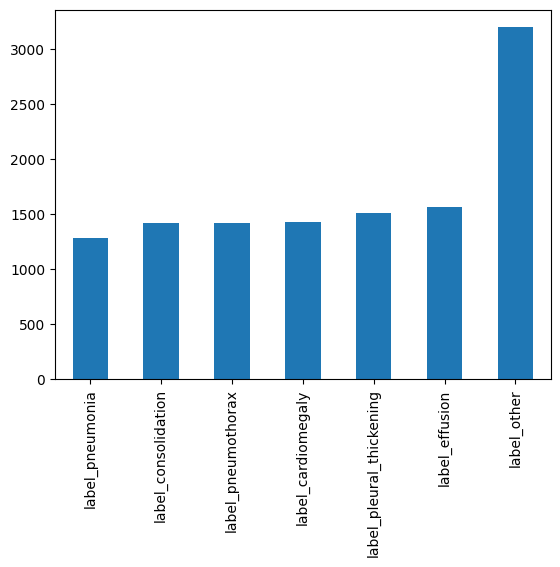

In [12]:
data_balanced[label_names].sum(axis=0).sort_values().plot(kind="bar");

We can use the remaining (i.e. not selected) data for our test set later on...

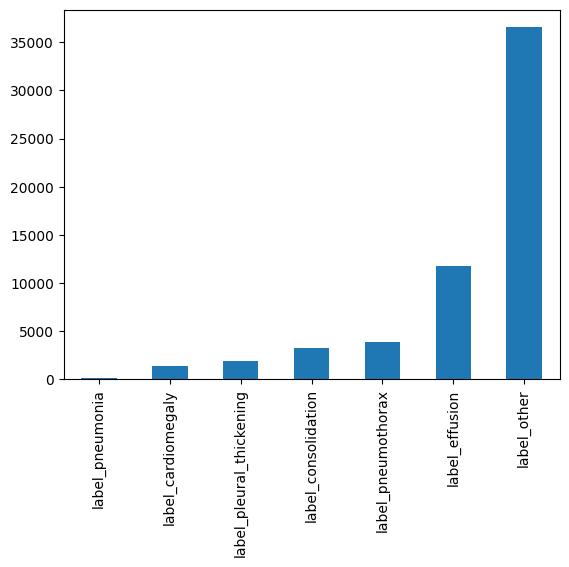

In [13]:
remaining_indices = data.index.difference(data_balanced.index)
remaining_data = data.loc[remaining_indices]
remaining_data[label_names].sum(axis=0).sort_values().plot(kind="bar");

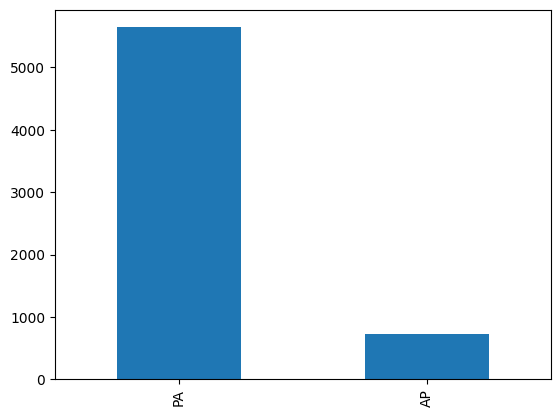

In [14]:
# TO DO: Try to prioritize Posterior-Anterior (PA) projection when building a balanced dataset
data_balanced.view_pos.value_counts().plot(kind="bar");

# Loading the Images

There are two ways to go about this:
1. Load the entire data set in memory if we have enough RAM, which we do. We estimate ~8000 images will take up between 4 to 8 gigabytes in RAM.
2. "Dataset generator": Keras has an "[image data generator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)".

## Loading the Entire Dataset

Let's try the first method first...

In [15]:
import os
import pathlib

import numpy as np
import PIL

In [16]:
def load_img(img_filename):
    data_dir = pathlib.Path("../raw_data/images_224_224")
    image_filename = img_filename
    image = PIL.Image.open(pathlib.Path(data_dir, image_filename))
    return image

In [17]:
n_images = data_balanced.shape[0]
example_img = load_img(data_balanced.iloc[0, :]["img_idx"])
img_dims = example_img.size
img_dims

(224, 224)

In [18]:
img_data = np.zeros((n_images, *img_dims))
img_data.shape

(6364, 224, 224)

In [19]:
# # This crashes Jupyter Notebook
# for img in data_balanced.loc[:, "img_idx"]:
#     # np.append(img_data, load_img(img))
#     pass

That was a dud. It crashes Jupyter Notebook. Let us now explore the second method.

## Generating the Dataset on the Fly

It turns out [`tf.keras.preprocessing.image.ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is deprecated and hence not recommended for new code. Neither it nor its successor, [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) are really applicable to our multi-label problem. (They are suited to single-label classification problems). I found [this blog post](https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72) on how to leverage the underlying API, [`tf.data`](https://www.tensorflow.org/guide/data) for multi-label problems. Let us explore that.

In [20]:
import tensorflow as tf


In [21]:
# from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input

# In order to do 'transfer learning' using VGG16, ResNet, etc. our image needs to have three channels.
# We will simply duplicate the one grayscale channel 2 more times.
def expand_greyscale_image_channels(image):
    if image.shape[-1] == 1:
        grey_image_3_channel = tf.tile(image, tf.constant([1, 1, 3], tf.int32))
    else:
        grey_image_3_channel = image

    return preprocess_input(grey_image_3_channel)

In [22]:
IMG_SIZE = 224  # img_dims[0]
CHANNELS = 3  # The images WERE grayscale but we converted them to 3-channel


def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = (
        image_decoded  # tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    )
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = tf.cast(image_resized, tf.float32) # / 255.0 The scaling is taken care of by `preprocess_input()` above
    image_normalized_rgb = expand_greyscale_image_channels(image_normalized)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.uint8)
    return image_normalized_rgb, label_tensor

In [23]:
cwd = os.getcwd()
data_dir = pathlib.Path(cwd, "..", "raw_data", "images_224_224")

# This works
img_norm_rgb, label_tensor = parse_function(
    str(pathlib.Path(data_dir, "00000009_000.png")),
    np.array([True, False, False, True]) + 0,
)
img_norm_rgb.shape

TensorShape([224, 224, 3])

(224, 224)

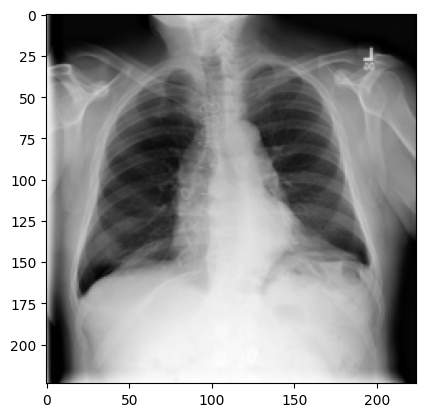

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread(pathlib.Path(data_dir, "00000009_000.png"))
plt.imshow(img, cmap="gray")
img.shape

In [67]:
BATCH_SIZE = 32 # 256  # The blog post suggested 256 is big enough to measure an F1-score but I suspect this was leading to this error while I was training the model: BiasGrad requires tensor size <= int32 max
AUTOTUNE = (
    tf.data.experimental.AUTOTUNE
)  # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = (
    256  # 1024  # Shuffle the training data by a chunck of 1024 observations
)

N_LABELS = len(label_names)

In [26]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [27]:
filenames = data_balanced.img_idx.to_list()
filepaths = [str(pathlib.Path(data_dir, filename)) for filename in filenames]
label_sets_binarized = np.array(
    data_balanced[label_names].apply(lambda x: x + 0), dtype=np.uint8
)

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train_bin, y_val_bin = train_test_split(
    filepaths, label_sets_binarized, test_size=0.2
)

In [29]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

We now, finally, have our training and validation data sets with the correct tensor sizes and data types.  
Now let's create the test set from the data that was _not_ selected while creating the balanced dataset. (Stored in `remaining_data`)

In [30]:
# Let's take a balanced subset...
test_data_balanced = remaining_data[remaining_data[rarest_label]]
n_min = test_data_balanced.shape[0]

for label, count in zip(label_counts_sorted.index[1:], label_counts_sorted[1:]):
    n_already_captured = test_data_balanced[test_data_balanced[label]].shape[0]
    n_additional = n_min - n_already_captured
    if n_additional > 0:
        not_selected_indices = remaining_data.index.difference(test_data_balanced.index)
        not_selected_data = remaining_data.loc[not_selected_indices]
        rows_to_add = not_selected_data[not_selected_data[label]].sample(n_additional)
        test_data_balanced = pd.concat([test_data_balanced, rows_to_add], axis=0)

test_data_balanced[label_names].sum(axis=0).sort_values()

label_pneumothorax          143
label_pneumonia             143
label_cardiomegaly          150
label_consolidation         150
label_pleural_thickening    153
label_effusion              180
label_other                 351
dtype: int64

In [31]:
filenames_test = test_data_balanced.img_idx.to_list()
X_test = [str(pathlib.Path(data_dir, filename)) for filename in filenames_test]
y_test_bin = np.array(
    test_data_balanced[label_names].apply(lambda x: x + 0), dtype=np.uint8
)
test_ds = create_dataset(X_test, y_test_bin)

# Modelling

## Loss Function and Evaluation Metrics

The function below, from [the Medium post mentioned earlier](https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72), will provide our evaluation metric:

In [32]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)

    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive

    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2 * tp / (2 * tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

And the one below, from a related blog post ([here](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d)), provides a differentiable version of the above, for our loss function:

In [33]:
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.

    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)

    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2 * tp / (2 * tp + fn + fp + 1e-16)
    cost = 1 - soft_f1  # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost)  # average on all labels

    return macro_cost

## Baseline Model

What if we just returned ones across the board? (i.e. naively predict that all patients have all of the conditions)  
Or if we randomly predicted the conditions based on their frequencies of occurrence?  
We need _something_ to compare our eventual model's evaluation metrics to.  
Let us explore this further now.

### Naive baseline #1: All ones across the board

In [34]:
pred_all_ones = np.ones(y_test_bin.shape)
macro_f1(y_test_bin, pred_all_ones)

<tf.Tensor: shape=(), dtype=float32, numpy=0.43346095>

In [35]:
from sklearn.metrics import classification_report

print(classification_report(y_test_bin, pred_all_ones, target_names=label_names))

                          precision    recall  f1-score   support

      label_cardiomegaly       0.24      1.00      0.38       150
          label_effusion       0.28      1.00      0.44       180
      label_pneumothorax       0.22      1.00      0.37       143
label_pleural_thickening       0.24      1.00      0.39       153
         label_pneumonia       0.22      1.00      0.37       143
     label_consolidation       0.24      1.00      0.38       150
             label_other       0.55      1.00      0.71       351

               micro avg       0.28      1.00      0.44      1270
               macro avg       0.28      1.00      0.43      1270
            weighted avg       0.33      1.00      0.48      1270
             samples avg       0.28      1.00      0.43      1270



### Naive Baseline #2: Random based on frequency

In [36]:
label_ratios = data_balanced[label_names].sum(axis=0) / len(data_balanced)
label_ratios

label_cardiomegaly          0.224544
label_effusion              0.245915
label_pneumothorax          0.223916
label_pleural_thickening    0.237901
label_pneumonia             0.202231
label_consolidation         0.223602
label_other                 0.503143
dtype: float64

In [37]:
pred_random_label_counts = round(y_test_bin.shape[0] * label_ratios)
pred_random_label_counts

label_cardiomegaly          143.0
label_effusion              157.0
label_pneumothorax          143.0
label_pleural_thickening    152.0
label_pneumonia             129.0
label_consolidation         142.0
label_other                 321.0
dtype: float64

In [38]:
pred_random = np.zeros(y_test_bin.shape)

for i, label in enumerate(label_names):
    pred_random[
        np.random.choice(
            pred_random.shape[0], int(pred_random_label_counts[label]), replace=False
        ),
        i,
    ] = 1

# pred_random.sum(axis=0)
macro_f1(y_test_bin, pred_random)

<tf.Tensor: shape=(), dtype=float32, numpy=0.29309282>

In [39]:
print(classification_report(y_test_bin, pred_random, target_names=label_names))

                          precision    recall  f1-score   support

      label_cardiomegaly       0.25      0.24      0.25       150
          label_effusion       0.26      0.23      0.24       180
      label_pneumothorax       0.22      0.22      0.22       143
label_pleural_thickening       0.28      0.27      0.28       153
         label_pneumonia       0.22      0.20      0.21       143
     label_consolidation       0.30      0.28      0.29       150
             label_other       0.59      0.54      0.56       351

               micro avg       0.35      0.32      0.33      1270
               macro avg       0.30      0.28      0.29      1270
            weighted avg       0.35      0.32      0.34      1270
             samples avg       0.31      0.31      0.28      1270



/Users/fafa/.pyenv/versions/3.10.6/envs/cxray/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Transfer Learning

We will be performing transfer learning using one of the many available pre-trained deep convolutional neural networks such as those listed in [this paper](https://www.nature.com/articles/s41598-020-70479-z.pdf?origin=ppubhttps://www.nature.com/articles/s41598-020-70479-z.pdf?origin=ppub).

In [68]:
LR = 1e-5  # For transfer learning, use a small value such as 1e5
EPOCHS = 50


def get_pretrained_model():
    pretrained_model = tf.keras.applications.vgg16.VGG16( # tf.keras.applications.resnet50.ResNet50(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
    )
    pretrained_model.trainable = False
    return pretrained_model

In [69]:
# pretrained = get_pretrained_model()
# pretrained.summary()

In [70]:
def create_compiled_custom_model():
    base_model = get_pretrained_model()
    flattening_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(250, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    dropout_layer_1 = tf.keras.layers.Dropout(0.4)
    dense_layer_2 = tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    dropout_layer_2 = tf.keras.layers.Dropout(0.2)
    dense_layer_3 = tf.keras.layers.Dense(50, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    dropout_layer_3 = tf.keras.layers.Dropout(0.1)
    prediction_layer = tf.keras.layers.Dense(N_LABELS, activation="sigmoid")

    model = tf.keras.models.Sequential(
        [
            base_model,
            flattening_layer,
            dense_layer_1,
            dropout_layer_1,
            dense_layer_2,
            dropout_layer_2,
            dense_layer_3,
            dropout_layer_3,
            prediction_layer,
        ]
    )

    opt = tf.keras.optimizers.Adam(learning_rate=LR)

    model.compile(
        optimizer=opt,
        loss=macro_soft_f1,
        metrics=[macro_f1],
    )

    return model

In [71]:
test_model = create_compiled_custom_model()
test_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 250)               6272250   
                                                                 
 dropout_9 (Dropout)         (None, 250)               0         
                                                                 
 dense_13 (Dense)            (None, 100)               25100     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 50)               

In [72]:
es = tf.keras.callbacks.EarlyStopping(
    # monitor="val_macro_f1", mode="max", patience=5, verbose=1, restore_best_weights=True
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=1,
    restore_best_weights=True,
)
history = test_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1, callbacks=[es]
)

Epoch 1/50
20/20 [==============================] - 430s 22s/step - loss: 0.7144 - macro_f1: 0.3564 - val_loss: 0.6801 - val_macro_f1: 0.3889
Epoch 2/50
20/20 [==============================] - 422s 21s/step - loss: 0.6742 - macro_f1: 0.3982 - val_loss: 0.6529 - val_macro_f1: 0.4176
Epoch 3/50
20/20 [==============================] - 417s 21s/step - loss: 0.6627 - macro_f1: 0.4088 - val_loss: 0.6476 - val_macro_f1: 0.4235
Epoch 4/50
20/20 [==============================] - 416s 21s/step - loss: 0.6566 - macro_f1: 0.4148 - val_loss: 0.6376 - val_macro_f1: 0.4341
Epoch 5/50
20/20 [==============================] - 401s 20s/step - loss: 0.6482 - macro_f1: 0.4226 - val_loss: 0.6222 - val_macro_f1: 0.4494
Epoch 6/50
20/20 [==============================] - 400s 20s/step - loss: 0.6409 - macro_f1: 0.4305 - val_loss: 0.6133 - val_macro_f1: 0.4570
Epoch 7/50
20/20 [==============================] - 400s 20s/step - loss: 0.6318 - macro_f1: 0.4402 - val_loss: 0.6084 - val_macro_f1: 0.4627
Epoch 

In [73]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    # --- LOSS: Soft Macro F1 ---
    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[0].set_title("Loss")
    ax[0].set_ylabel("Soft Macro F1")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train", "Validation"], loc="best")
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)

    # --- METRICS: Macro F1 ---

    ax[1].plot(history.history["macro_f1"])
    ax[1].plot(history.history["val_macro_f1"])
    ax[1].set_title("Metric")
    ax[1].set_ylabel("Macro F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train", "Validation"], loc="best")
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)

    return ax

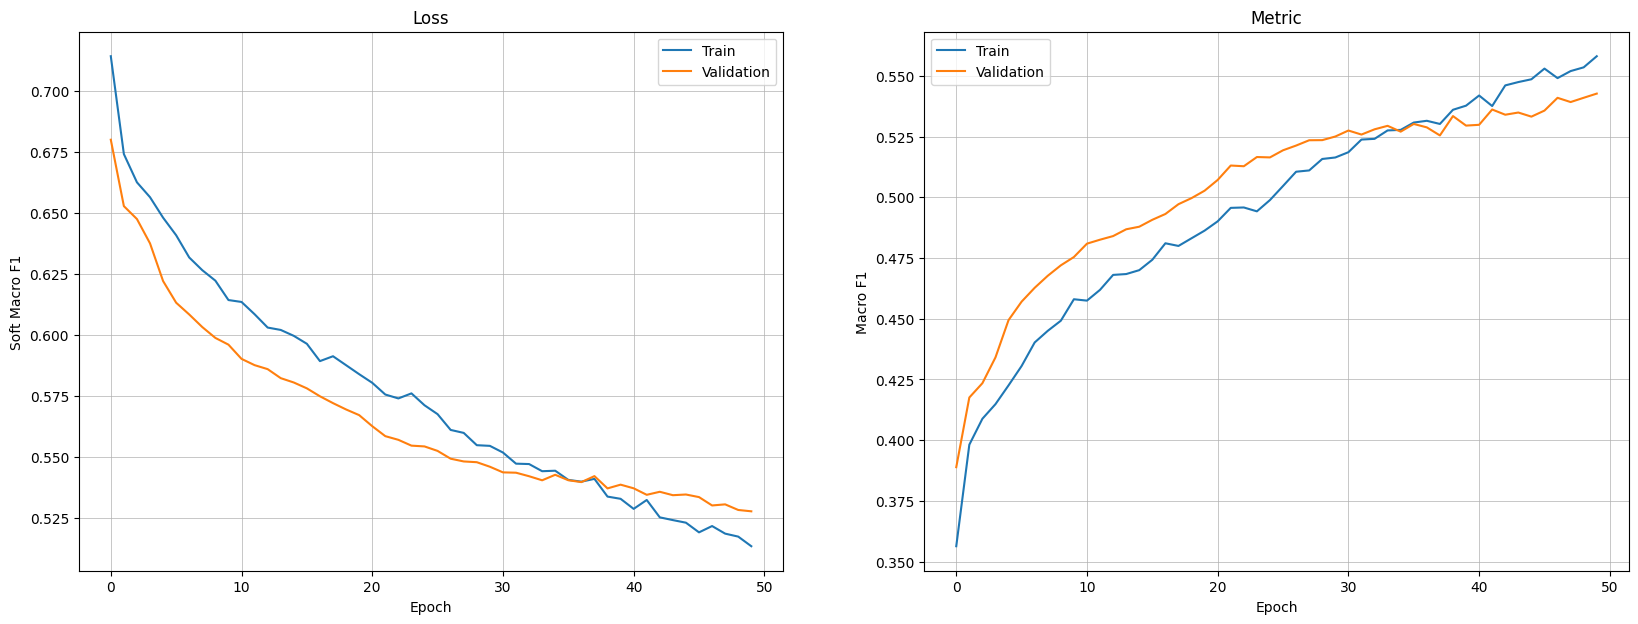

In [74]:
plot_history(history);

In [75]:
res = test_model.evaluate(test_ds, return_dict=True)
res

3/3 [==============================] - 39s 11s/step - loss: 0.6958 - macro_f1: 0.3631


{'loss': 0.6958465576171875, 'macro_f1': 0.36313602328300476}

In [76]:
import pickle

filename = "test_model_vgg16_bs32_do40-20-10_l2-0001.pickle"
pickle.dump(test_model, open(filename, "wb"))

# loaded_model = pickle.load(open(filename, "rb"))

INFO:tensorflow:Assets written to: ram://990eb2e0-b6fe-4bf8-87c9-b9e21e7fd28b/assets


INFO:tensorflow:Assets written to: ram://990eb2e0-b6fe-4bf8-87c9-b9e21e7fd28b/assets


In [77]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = test_model.predict(image_batch)
   # append predicted labels
#    y_pred.append(preds)
#    y_pred.append((preds > 0.5))
   y_pred.append((preds > 0.5) * 1)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

4/4 [==============================] - 7s 2s/step


In [78]:
from sklearn.metrics import classification_report
labels_array = np.array(label_names)
y_true = correct_labels
y_pred = predicted_labels

In [79]:
print(classification_report(y_true, y_pred , target_names=label_names))

                          precision    recall  f1-score   support

      label_cardiomegaly       0.50      0.17      0.25       150
          label_effusion       0.28      1.00      0.44       180
      label_pneumothorax       0.44      0.34      0.38       143
label_pleural_thickening       0.39      0.42      0.41       153
         label_pneumonia       0.18      0.52      0.27       143
     label_consolidation       0.10      0.17      0.12       150
             label_other       0.55      1.00      0.71       351

               micro avg       0.34      0.61      0.43      1270
               macro avg       0.35      0.52      0.37      1270
            weighted avg       0.38      0.61      0.43      1270
             samples avg       0.34      0.56      0.41      1270

